### Imports and device selection

Load all PyTorch, torchvision, and plotting dependencies, then choose the fastest available accelerator (MPS/GPU/CPU) for training.

In [24]:
# ------------------------
# 1. Imports & setup
# ------------------------
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
import numpy as np
from torchvision import models
from torch.nn import functional as F
from pathlib import Path
from shutil import copy2
import json
from PIL import Image
import pandas as pd

# Device: MPS (Apple Silicon GPU) if available, else CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


### Loaders and augmentations

Apply light image augmentation for the training set, standard normalization, and build `DataLoader`s pointing at the `train/` and `test/` folders.

In [14]:
# ------------------------
# 2. Data preparation
# ------------------------
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

train_dir = "train"
test_dir = "test"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['FAKE', 'REAL']


### Initialise transfer-learning backbone

Start from ImageNet-pretrained ResNet‑18, replace the classifier head for two classes, and set up the loss/optimizer.

In [ ]:
# ------------------------
# 3. Model (ResNet-18 for speed)
# ------------------------
model    = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # binary classifier
model    = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


### Epoch loop

Iterate over the loaders, update weights, and capture running loss/accuracy so we can inspect learning curves later.

In [16]:
# ------------------------
# 4. Training loop
# ------------------------
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=3):
    history = {"loss": [], "acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        history["loss"].append(epoch_loss)
        history["acc"].append(epoch_acc)

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")

    return model, history

MODEL_PATH = Path("resnet18_fake_detector.pth")
HISTORY_PATH = Path("training_metrics.json")

history = None
if MODEL_PATH.exists():
    state_dict = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(state_dict)
    print(f"Loaded pretrained weights from {MODEL_PATH.resolve()}")
    if HISTORY_PATH.exists():
        try:
            saved_metrics = json.loads(HISTORY_PATH.read_text())
            history = {
                "loss": saved_metrics.get("loss") or saved_metrics.get("losses") or [],
                "acc": saved_metrics.get("accuracy") or saved_metrics.get("acc") or [],
            }
            print(f"Loaded training metrics from {HISTORY_PATH.resolve()}")
        except Exception as err:
            print(f"Warning: failed to load history from {HISTORY_PATH.name}: {err}")
            history = {"loss": [], "acc": []}
    else:
        print("No cached training metrics found; history will be empty.")
        history = {"loss": [], "acc": []}
else:
    model, history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=3)
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Saved new weights to {MODEL_PATH.resolve()}")

if history is None:
    history = {"loss": [], "acc": []}


Epoch 1/3 - Loss: 0.1347 - Acc: 0.9481
Epoch 2/3 - Loss: 0.0836 - Acc: 0.9689
Epoch 3/3 - Loss: 0.0655 - Acc: 0.9760


### Evaluate on hold-out images

Switch to eval mode, accumulate predictions on the test loader, and report precision/recall plus a confusion matrix.


Classification report:

              precision    recall  f1-score   support

        FAKE       0.97      0.98      0.98     10000
        REAL       0.98      0.97      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



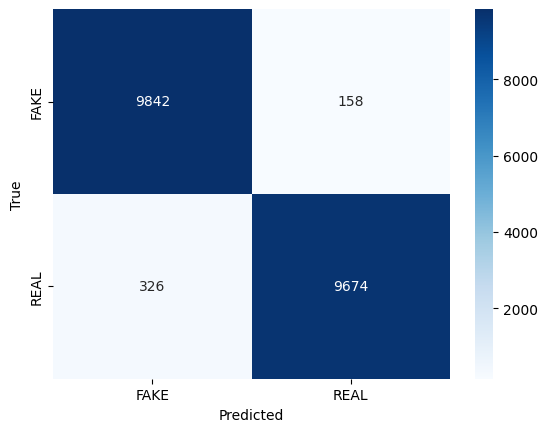

In [17]:
# ------------------------
# 5. Evaluation
# ------------------------
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

report_dict = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True,
)
report_df = pd.DataFrame(report_dict).T

print("
Classification report (rounded):
")
print(report_df.round(3))

report_path = Path('classification_report.tsv')
report_df.to_csv(report_path, sep='	')
print(f"Saved classification report to {report_path.resolve()}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=class_names,
    yticklabels=class_names,
    cmap='Blues',
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Plot learning dynamics

Visualise loss and accuracy history from training to confirm the model is converging.

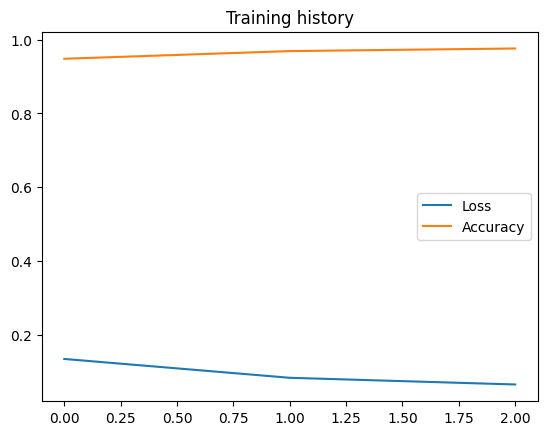

In [18]:
# ------------------------
# 6. Training curves
# ------------------------
plt.plot(history['loss'], label='Loss')
plt.plot(history['acc'], label='Accuracy')
plt.legend()
plt.title('Training history')
plt.show()

plot_payload = {
    'epoch': list(range(1, len(history['loss']) + 1)),
    'loss': history['loss'],
    'accuracy': history['acc'],
}
plot_path = Path('training_metrics.json')
plot_path.write_text(json.dumps(plot_payload, indent=2))
print(f"Saved training metrics to {plot_path.resolve()}")


### Grad-CAM inspection

Run single-image inference, backpropagate through the last conv block, and overlay the activation heatmap to explain each decision.

REAL IMAGE TEST


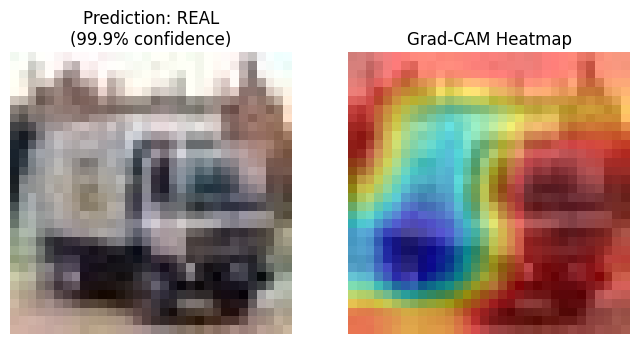

FAKE IMAGE TEST


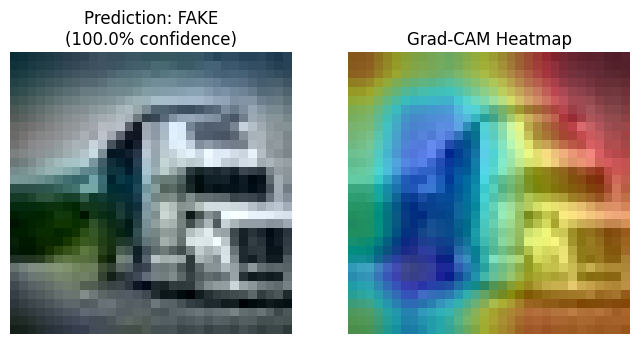

In [28]:
# ------------------------
# Single-image test with Grad-CAM
# ------------------------

def predict_and_gradcam(img_path, model, transform, class_names, target_layer):
    img = Image.open(img_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)

    activations = {}

    def hook_fn(m, i, o):
        activations['value'] = o
        o.retain_grad()  # keep grad for non-leaf tensor

    handle = target_layer.register_forward_hook(hook_fn)

    model.eval()
    outputs = model(img_t)
    handle.remove()

    probs = torch.softmax(outputs, dim=1)[0].detach().cpu().numpy()
    pred_idx = int(np.argmax(probs))
    pred_label = class_names[pred_idx]
    confidence = float(probs[pred_idx] * 100)

    # Backward pass for predicted class
    model.zero_grad()
    outputs[0, pred_idx].backward()

    # Get grads + activations
    grads = activations['value'].grad.detach().cpu()[0].numpy()
    fmap = activations['value'].detach().cpu()[0].numpy()

    weights = grads.mean(axis=(1, 2))  # importance per channel
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * fmap[i]

    cam = np.maximum(cam, 0)
    if cam.max() > 0:
        cam /= cam.max()
    cam = cv2.resize(cam, (img.size[0], img.size[1]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(img), 0.5, heatmap, 0.5, 0)

    # Show results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {pred_label}
({confidence:.1f}% confidence)")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('Grad-CAM Heatmap')
    plt.show()

    return {
        'image_path': img_path,
        'predicted_label': pred_label,
        'confidence_percent': confidence,
        'probabilities': probs.tolist(),
    }

# ------------------------
# Pick one REAL and one FAKE from test set
# ------------------------
real_img_path, _ = [s for s in test_dataset.samples if 'REAL' in s[0]][0]
fake_img_path, _ = [s for s in test_dataset.samples if 'FAKE' in s[0]][0]

# Use the last conv layer of ResNet-18
target_layer = model.layer4[1].conv2

# Run predictions + heatmaps
print('REAL IMAGE TEST')
real_result = predict_and_gradcam(real_img_path, model, test_transform, class_names, target_layer)

print('FAKE IMAGE TEST')
fake_result = predict_and_gradcam(fake_img_path, model, test_transform, class_names, target_layer)


In [ ]:
# ------------------------
# 7. Export artefacts
# ------------------------
root_dir = Path.cwd()

# Copy inspected images to notebook root
images_to_copy = [
    ('real', Path(real_result['image_path'])),
    ('fake', Path(fake_result['image_path'])),
]
manifest = {
    'training_metrics_json': Path('training_metrics.json').name,
    'classification_report_tsv': Path('classification_report.tsv').name,
    'examples': [],
}

for label, src in images_to_copy:
    dst = root_dir / src.name
    if not dst.exists() or src.resolve() != dst.resolve():
        copy2(src, dst)
    result = real_result if label == 'real' else fake_result
    manifest['examples'].append(
        {
            'type': label,
            'image_filename': dst.name,
            'prediction': result['predicted_label'],
            'confidence_percent': result['confidence_percent'],
            'probabilities': result['probabilities'],
        }
    )

manifest_path = Path('gradcam_results.json')
manifest_path.write_text(json.dumps(manifest, indent=2))
print(f"Saved Grad-CAM manifest to {manifest_path.resolve()}")
